In [14]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [4]:
from sklearn.datasets import load_boston
boston = load_boston()

In [5]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data = data[(data["MEDV"] < 50)]
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
X_filtered = data[["RM", "LSTAT"]]
Y_filtered = data["MEDV"]
X, Y = np.array(X_filtered), np.array(Y_filtered)

In [117]:
class GDRegressor:
    
    def __init__(self, alpha=0.01, n_iter=100):
        self.alpha = alpha
        self.n_iter = n_iter

    def fit(self, X, y):
        X = np.hstack([np.ones((len(X), 1)), X]) 
        theta = np.zeros(X.shape[1]) 
        self.theta_history = theta.copy()
        m = len(X)   
        self.loss_history = []
        for i in range(self.n_iter):
            predictions = X.dot(theta)
            error = X.dot(theta) - y 
            gradient = (1 / m) * (X.T.dot(error))
            theta -= self.alpha * gradient
            self.theta_history = np.vstack([self.theta_history,theta])
            loss = np.sum((predictions - y)**2) / (2 * m)            
            self.loss_history.append(loss)
        self.theta = theta
        self.intercept_ = theta[0]
        self.coef_ = theta[1:]

    def predict(self, X_test):
        return np.hstack([np.ones((len(X_test), 1)), X_test]).dot(self.theta)
    

In [7]:
model = GDRegressor()
model.fit(X, Y)

In [8]:
def z_scaler(X):
    if len(X.shape) == 1:
        mean = sum(X) / len(X)
        std = sqrt(sum([(x - mean) ** 2 for x in X]) / (len(X) - 1))
        X = [(x - mean) / std for x in X]
        return X
    for col in X.columns:
        mean = sum(X[col]) / len(X[col])
        std = sqrt(sum([(x - mean) ** 2 for x in X[col]]) / (len(X[col]) - 1))
        X[col] = [(x - mean) / std for x in X[col]]
        return X

In [9]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(Y_filtered)

In [138]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.0026, n_iter=30000)

%time model.fit(X_train, Y_train)

CPU times: user 2.11 s, sys: 78.1 ms, total: 2.18 s
Wall time: 2.19 s


In [136]:
def plot_loss_function(model):
    plt.xlabel("Iterations")
    plt.ylabel("Average square loss")
    plt.plot(np.arange(model.n_iter), model.loss_history);

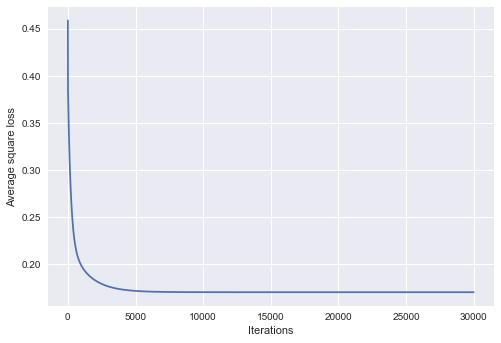

In [139]:
plot_loss_function(model)

In [140]:
def rmse(y_hat, y):
    sum1 = 0
    for i in range(len(list(y_hat))):
        sum1 += (list(y)[i] - list(y_hat)[i])**2
    result = (sum1 / len(y))**0.5
    return result

In [141]:
def r_squared(y_hat, y):
    y_mean = np.mean(y)
    sum1 = sum2 = 0
    for i in range(len(list(y))):
        sum1 += (list(y)[i] - list(y_hat)[i])**2
        sum2 += (list(y)[i] - y_mean)**2
    result = 1 - (sum1 / sum2)
    return result

In [142]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(0.5953591313324416, 0.6929130877657086)

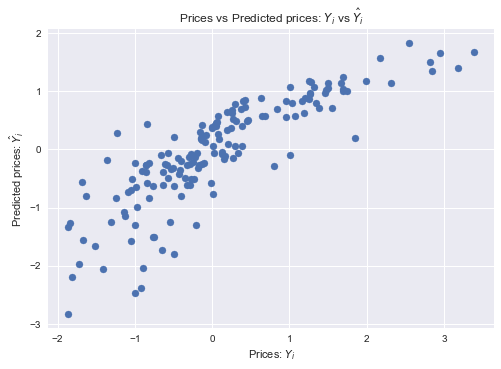

In [143]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

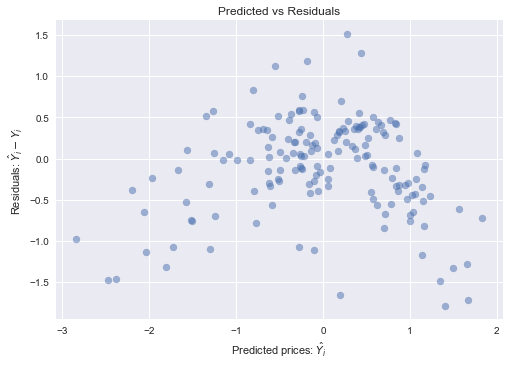

In [144]:
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
plt.scatter(Y_pred, (Y_pred - np.ravel(Y_test)), alpha=0.5);

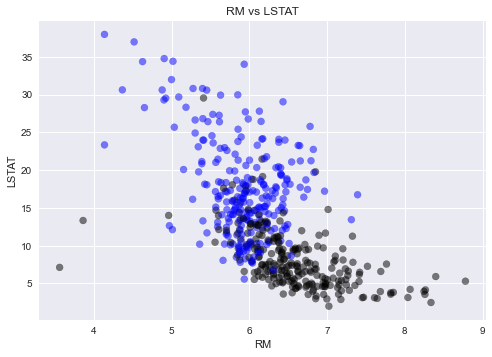

In [145]:
colors = ['k' if v > data["MEDV"].median() else 'b' for v in data["MEDV"]]
plt.scatter(data["RM"], data["LSTAT"], c=colors, alpha=0.5)
plt.xlabel("RM");
plt.ylabel("LSTAT");
plt.title("RM vs LSTAT")
plt.show()

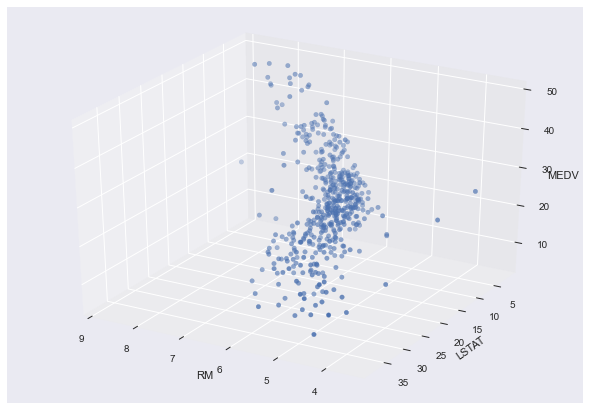

In [146]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()#figsize=(15, 10))
ax = Axes3D(fig)
ax.set_xlabel('RM')
ax.set_ylabel('LSTAT')
ax.set_zlabel('MEDV');
ax.view_init(azim=120)
ax.scatter3D(data["RM"], data["LSTAT"], data["MEDV"])
plt.show()

Добавление полиномиальных признаков

In [147]:
from sklearn.preprocessing import PolynomialFeatures

In [101]:
poly = PolynomialFeatures(4, include_bias=False)
X_filtered_poly = poly.fit_transform(X_filtered)

In [103]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, Y_filtered, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [104]:
model = SGDRegressor(
    loss='squared_loss',
    penalty='l1',
    alpha=0.01,
    learning_rate='constant',
    max_iter=1000,
    eta0=0.005
)
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.01, eta0=0.005, learning_rate='constant', penalty='l1')

In [105]:
Y_pred = model.predict(X_test)

In [106]:
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.306131381543202, 0.7571188377954787)

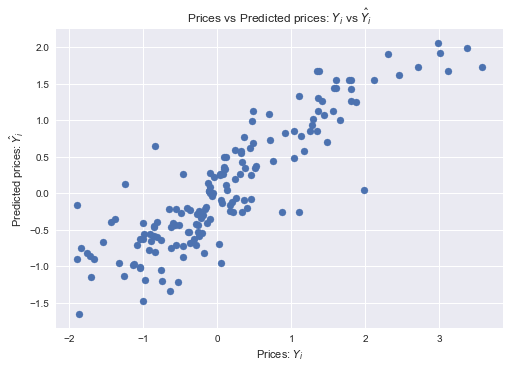

In [107]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

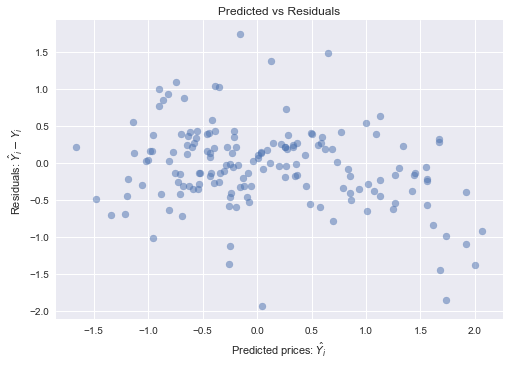

In [108]:
fig = plt.figure()
plt.scatter(Y_pred, (Y_pred-Y_test.reshape(1, -1)), alpha=0.5);
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
fig.savefig('lr_residuals3.png', dpi=fig.dpi)

In [109]:
model.coef_, model.intercept_

(array([ 0.45827781, -0.55748682,  0.51246905, -0.02681798, -0.02172517,
        -0.25446964,  0.        , -0.2011904 ,  0.        , -0.45248334,
         0.        , -0.12787366, -0.12034117,  0.        ]),
 array([-0.00709471]))

In [110]:
poly.get_feature_names(X_filtered.columns)

['RM',
 'LSTAT',
 'RM^2',
 'RM LSTAT',
 'LSTAT^2',
 'RM^3',
 'RM^2 LSTAT',
 'RM LSTAT^2',
 'LSTAT^3',
 'RM^4',
 'RM^3 LSTAT',
 'RM^2 LSTAT^2',
 'RM LSTAT^3',
 'LSTAT^4']

Построение кривых обучения

In [111]:
def learning_curves(estimator, data, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(str(features), fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,70)

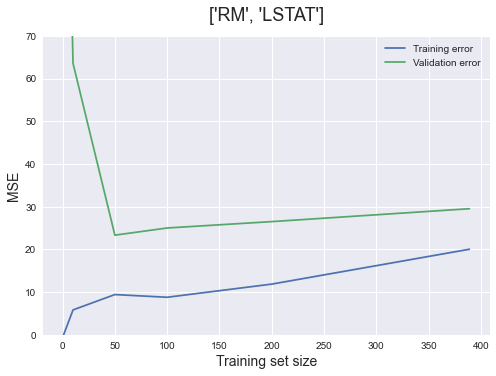

In [112]:
train_sizes = [1, 10, 50, 100, 200, 389]
target = 'MEDV'
features = ['RM', 'LSTAT']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

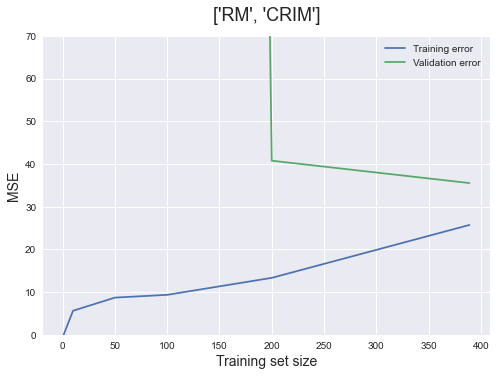

In [113]:
features = ['RM', 'CRIM']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

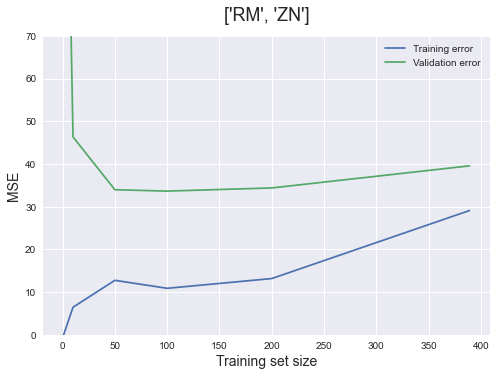

In [148]:
features = ['RM', 'ZN']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

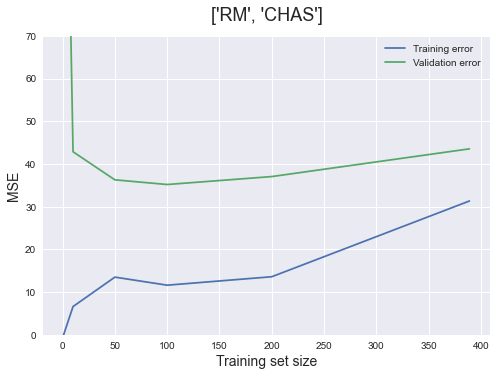

In [149]:
features = ['RM', 'CHAS']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

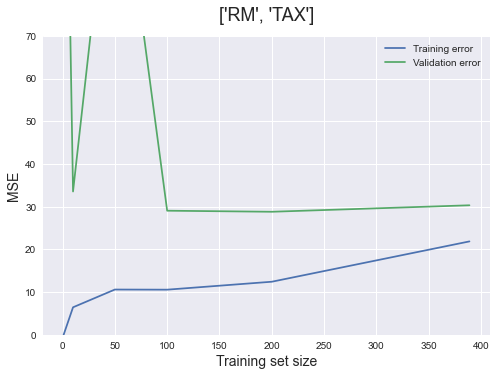

In [150]:
features = ['RM', 'TAX']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

In [151]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT", "ZN", "PTRATIO"]]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [152]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [175]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.001, n_iter=10000)
%time model.fit(X_train, Y_train)

CPU times: user 653 ms, sys: 24.1 ms, total: 677 ms
Wall time: 680 ms


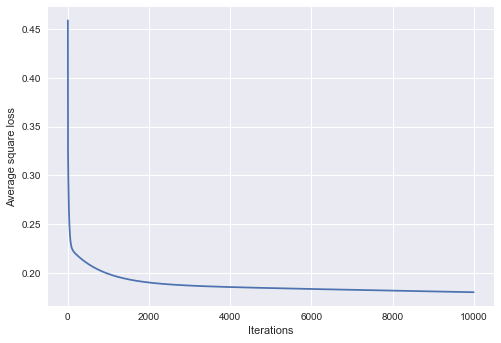

In [177]:
plot_loss_function(model)ц

In [25]:
class GDRegressor:
    
    def __init__(self, alpha=0.01, n_iter=100):
        self.alpha = alpha
        self.n_iter = n_iter

    def fit(self, X, y):
        X = np.hstack([np.ones((len(X), 1)), X]) 
        theta = np.zeros(X.shape[1]) 
        self.theta_history = theta.copy()
        m = len(X)   
        self.loss_history = []
        for i in range(self.n_iter):
            predictions = X.dot(theta)
            error = X.dot(theta) - y 
            gradient = (1 / m) * (X.T.dot(error))
            theta -= self.alpha * gradient
            self.theta_history = np.vstack([self.theta_history,theta])
            loss = np.sum((predictions - y)**2) / (2 * m)            
            self.loss_history.append(loss)
        self.theta = theta
        self.intercept_ = theta[0]
        self.coef_ = theta[1:]

    def predict(self, X_test):
        return np.hstack([np.ones((len(X_test), 1)), X_test]).dot(self.theta) 
    def lasso(self, X, y):
        lasso = Lasso(max_iter=2500)
        params = {"alpha":[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
        self.lasso_regressor = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)
        self.lasso_regressor.fit(X_filtered, Y_filtered)
        return self.lasso_regressor.best_params_, self.lasso_regressor.best_score_

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.0026, n_iter=3000)
%time model.fit(X_train, Y_train)

CPU times: user 172 ms, sys: 5.39 ms, total: 177 ms
Wall time: 176 ms


In [33]:
model.lasso(X_train, Y_train)

({'alpha': 1e-08}, -29.494786869433927)